This is a comprehensive demonstration of fastai on an image dataset. [Fast.ai](https://github.com/fastai/fastai) is a deep learning library which uses pytorch as its backend. So, in many ways, it is more modern and robust than tensorflow based libraries like keras.

For this analysis, a plant disease dataset is being used to detect and diagose plant based diseases. Plant diseases are a major threat to food security and it is important to diagnose these diseases early and accurately. This can lead to a better future for food self-sufficiency, efficient waste management etc. The domain of plant disease diagnosis has experienced a huge progress as technology has evolved -- from visual depiction of symptoms to a molecular level detection. In this notebook, we are looking to detect these diseases from images of the leaves of healthy and diseased plants.

# Importing Libraries and Looking at the Data

In [1]:
from fastai import *
from fastai.vision import *
import os
from os import listdir
%reload_ext autoreload
%autoreload 2
%matplotlib inline
path = "../input/plantvillage/PlantVillage/"
os.listdir(path)

['Potato___healthy',
 'Potato___Early_blight',
 'Tomato_Early_blight',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Late_blight',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Leaf_Mold',
 'Pepper__bell___healthy']

So, in the dataset, we will be largely looking at the healthy and diseased variants of the leaves of tomato, potato and pepper. This is a classification problem where we have 15 labels or ground truths.

In [2]:
path = Path(path); path

PosixPath('../input/plantvillage/PlantVillage')

In [3]:
directory_root = '../input/plantvillage/'
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(image_directory)
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Image loading completed


After getting the data, we can use the `get_transforms` function to add variation, say, flipping the image vertically.

In [4]:
tfms = get_transforms(flip_vert=True, max_warp=0., max_zoom=0., max_rotate=0.)

It is very essential that one figures out how to get the labels, i.e. the ground truths from which the model can learn. Different kinds of datasets will have different ways to get the labels.

Let's take a sample file and get its label

In [5]:
file_path = '../input/plantvillage/PlantVillage/Potato___Early_blight/0faca7fe-7254-4dfa-8388-bbc776338c9c___RS_Early.B 7929.JPG'

In [6]:
dir_name = os.path.dirname(file_path)

One can see that the label is present in the file path itself (`Potato___Early_blight`) and to get it we can split the string with respect to `/` and get all the words separated by `/` into a list. From that list we can easily access the label.

In [7]:
dir_length = len(dir_name.split("/"))
dir_name.split("/")

['..', 'input', 'plantvillage', 'PlantVillage', 'Potato___Early_blight']

In [8]:
dir_name.split("/")[dir_length - 1]

'Potato___Early_blight'

We got the label!
Now, to generalise for all image files, we can create a function `get_labels` that performs the above steps.

In [9]:
def get_labels(file_path): 
    dir_name = os.path.dirname(file_path)
    split_dir_name = dir_name.split("/")
    dir_length = len(split_dir_name)
    label  = split_dir_name[dir_length - 1]
    return(label)

Now that we are ready with the images and their corresponding labels, we can generate the data. We will also normalise so that all the pixel values have the same mean and standard deviation. This will help the model to learn more easily and faster.

In [10]:
data = ImageDataBunch.from_name_func(path, image_list, label_func=get_labels,  size=224, 
                                     bs=64,num_workers=2,ds_tfms=tfms)
data = data.normalize()

Let's take a look at a random sample of the data.

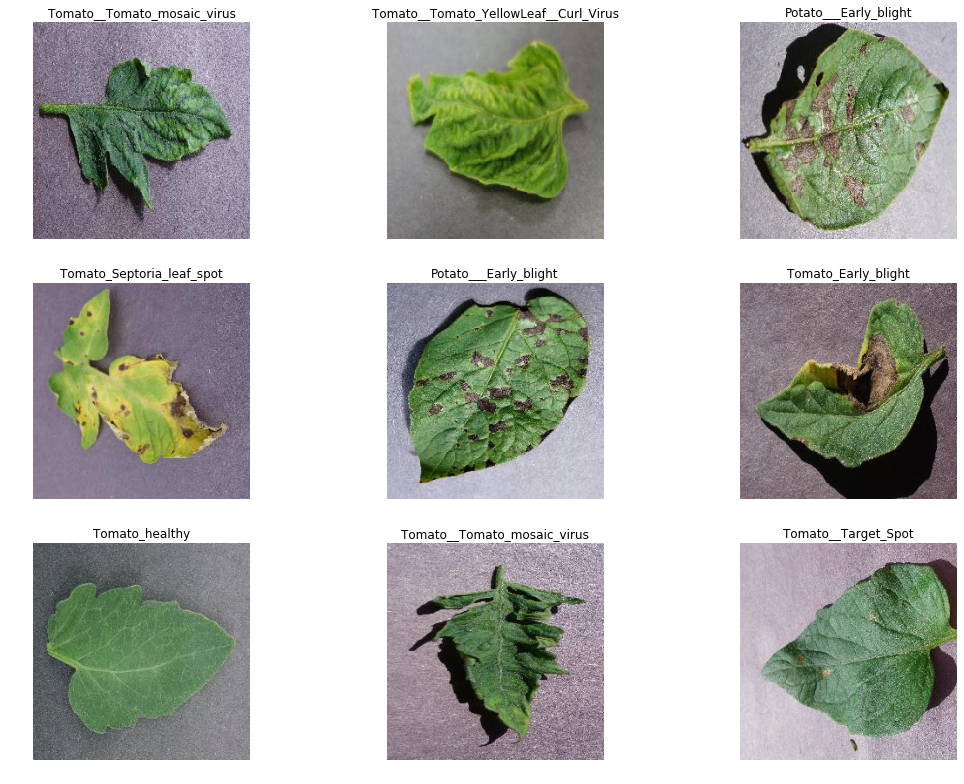

In [11]:
data.show_batch(rows=3, figsize=(15,11))

In [12]:
learn = cnn_learner(data, models.resnet101, metrics=error_rate, model_dir='/tmp/models/')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 152MB/s]


In [13]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.916464,0.551151,0.177966,00:23
1,0.986693,0.397822,0.128814,00:20
2,0.657643,0.350005,0.115254,00:20
3,0.475985,0.293291,0.094915,00:20
4,0.348630,0.210363,0.064407,00:19
5,0.249584,0.184830,0.064407,00:20
6,0.186369,0.174370,0.054237,00:20
7,0.154039,0.164407,0.055932,00:19
8,0.123338,0.151689,0.049153,00:20
9,0.099514,0.155794,0.049153,00:20


In just 10 epochs, the model achieves a substantially high accuracy! Now let's see what were the most confident but wrong predictions so that we can further fine tune.

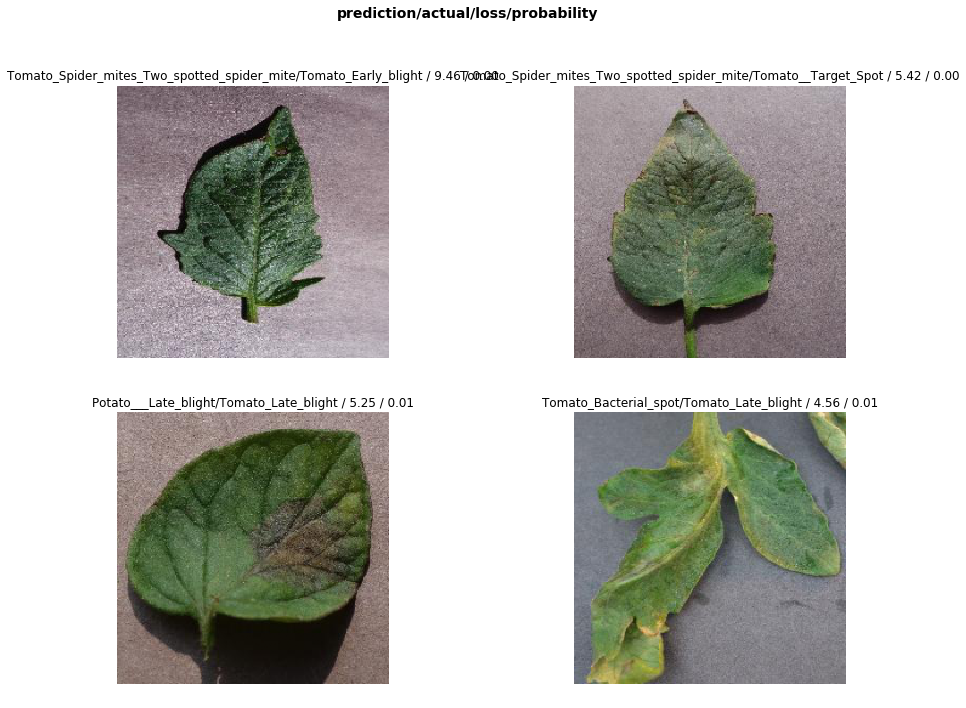

In [14]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

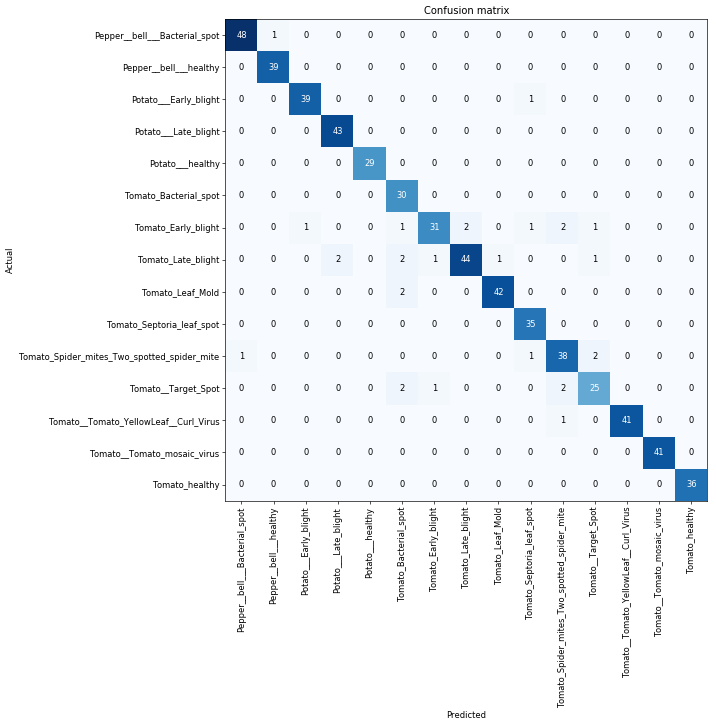

In [15]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interpretation.most_confused(min_val=2)

[('Tomato_Early_blight', 'Tomato_Late_blight', 2),
 ('Tomato_Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 2),
 ('Tomato_Late_blight', 'Potato___Late_blight', 2),
 ('Tomato_Late_blight', 'Tomato_Bacterial_spot', 2),
 ('Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 2),
 ('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 2),
 ('Tomato__Target_Spot', 'Tomato_Bacterial_spot', 2),
 ('Tomato__Target_Spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 2)]

# Fine Tuning

In [17]:
learn.save('classification-1')

In [18]:
learn.load('classification-1')

Learner(data=ImageDataBunch;

Train: LabelList (2362 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Potato___healthy,Potato___healthy,Potato___healthy,Potato___healthy,Potato___healthy
Path: ../input/plantvillage/PlantVillage;

Valid: LabelList (590 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tomato__Tomato_mosaic_virus,Pepper__bell___healthy,Tomato_Septoria_leaf_spot,Potato___Late_blight,Tomato_Leaf_Mold
Path: ../input/plantvillage/PlantVillage;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0):

In [19]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.550161,0.489033,0.132203,00:23


As soon as we let the model un-learn, its error rate becomes significantly higher. So, one should find an optimum learning rate at which the model should learn.

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


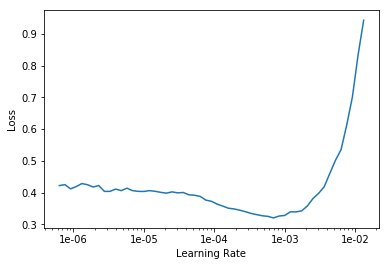

In [21]:
learn.recorder.plot()

From the plot, it is clear that the loss increases very fast as the learning rate increases beyond 0.001. So, let's keep the learning rate within a range of 0.000001 to 0.001

In [22]:
learn.unfreeze()
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.269821,0.189325,0.050847,00:23
1,0.185894,0.144065,0.037288,00:22
2,0.155472,0.103806,0.044068,00:22
3,0.123874,0.081355,0.035593,00:22
4,0.081953,0.057964,0.018644,00:22
5,0.058292,0.050574,0.016949,00:22


On fine tuning, we achieve a much higher accuracy and a much lower error rate. Let's again look at the confidently wrong predictions.

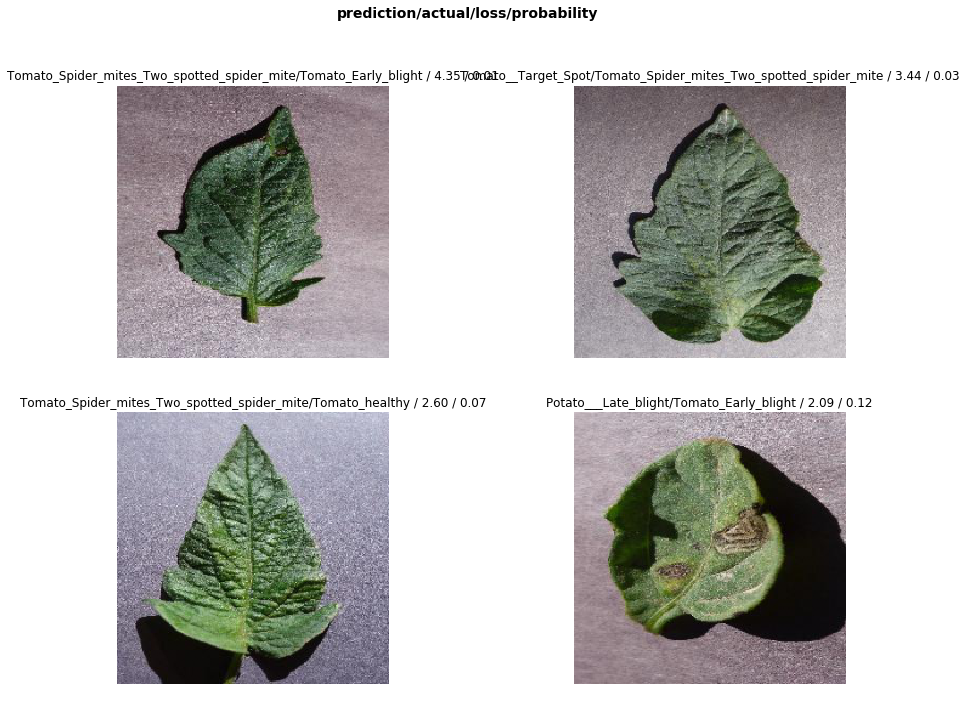

In [23]:
interpretation = ClassificationInterpretation.from_learner(learn)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(15,11))

In [24]:
interpretation.most_confused(min_val=2)

[('Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 2)]

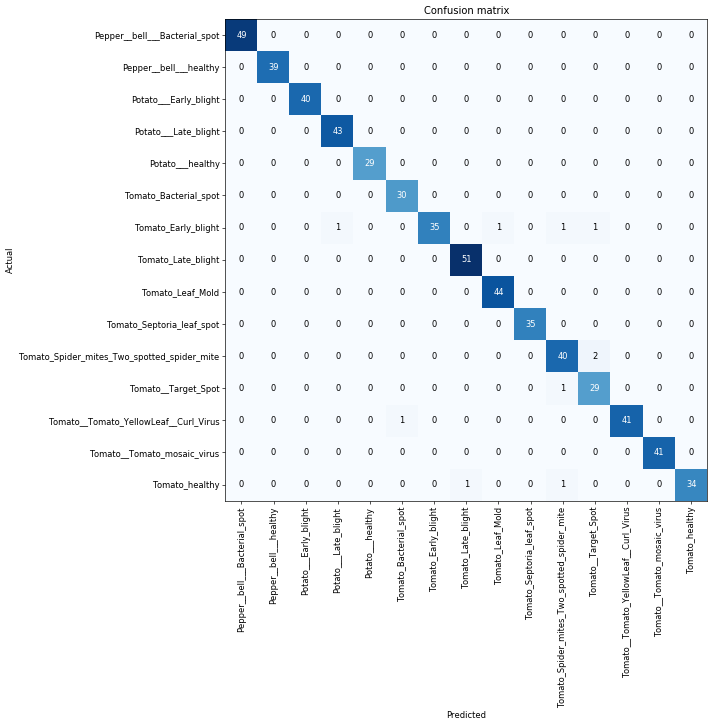

In [25]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
learn.save('resnet50-classifier.pkl')

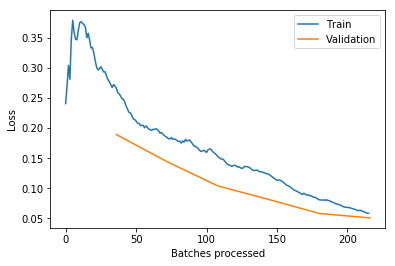

In [27]:
learn.recorder.plot_losses()

In [28]:
os.chdir("/tmp/models/")